In [0]:
#"""
!pip install nptyping
!pip install ml_metrics
!pip install hyperopt
#"""

Здесь происходит оптимизация и обучение алгоритма MiniBatchKMeans на сжатой усеченной матрице сопряженности исполнителей.

In [0]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, vstack, load_npz
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import ml_metrics 
from typing import Dict, Any
from nptyping import NDArray
from sklearn.cluster import AffinityPropagation, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import davies_bouldin_score

from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt import hp
from matplotlib import pyplot as plt

DATA_DIR = './drive/My Drive/Colab Notebooks/VK_internship/'
sys.path.append(DATA_DIR)
recommendation = __import__("recommendation") 

Усеченная матрица смежности исполнителей:

In [0]:
train_matrix = load_npz(DATA_DIR+"train_matrix.npz")
test_matrix = load_npz(DATA_DIR+"test_matrix.npz")
user_artists_df = pd.read_csv(DATA_DIR+"users_artists.csv", usecols=["user_id", "artists"]).drop_duplicates()

artists_id = user_artists_df["artists"].unique()
artists_id.sort()
train, test = train_test_split(artists_id, test_size=0.1)
del artists_id

partial_user_artists_df = user_artists_df.loc[user_artists_df["artists"].isin(train)]
del train
partial_artists = partial_user_artists_df.groupby("artists").count().reset_index()
del partial_user_artists_df
partial_artists = partial_artists.sort_values(by="user_id", ascending = False)
partial_artists_rows = partial_artists.loc[:,"artists"].values
del partial_artists

In [0]:
non_zero_rows_idxs = np.unique(train_matrix.nonzero()[0])
train_matrix = train_matrix[non_zero_rows_idxs, :]

Понижение размерности:

In [0]:
svd = TruncatedSVD(n_components=500, random_state=42) 
# по-хорошему надо посмотреть, как ведут себя модели при разных значениях 
# n_components, чтобы по оценкам качества понять, 
# какое знаяение более всего подходит
reducted_train_matrix = svd.fit_transform(train_matrix)
reducted_test_matrix = svd.transform(test_matrix)

Оптимизация гиперпараметров алгоритма:

MiniBatchKMeans:

Сначала стоит определить количество кластеров:

In [0]:
def find_clusters_amount_for_KMeans(
    train_matrix: csr_matrix, 
    min_amount: int, 
    max_amount: int, 
    step: int
) -> NDArray[(Any,), float]:
    scores = np.array([])
    for clusters_amount in range(min_amount, max_amount, step):
        estimator = MiniBatchKMeans(batch_size=100000, n_clusters = clusters_amount)
        estimator = estimator.fit(train_matrix)
        if len(np.unique(estimator.labels_))< len(estimator.labels_):
            scores = np.append(scores, davies_bouldin_score(train_matrix, estimator.labels_))
        else:
            scores = np.append(scores, 1000)
    return scores

В связи с острой нехваткой времени было сделано всего точки, что является крайне малым для определения оптимального количества кластеров. 

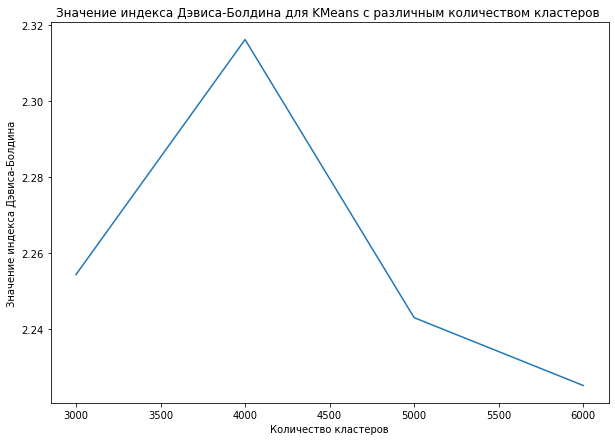

In [7]:
left = 3000
right = 7000
step = 1000
scores = find_clusters_amount_for_KMeans(reducted_train_matrix, left, right, step)

plt.figure(figsize=(10,7))
plt.plot(range(left, right, step), scores)

plt.title("Значение индекса Дэвиса-Болдина для KMeans с различным количеством кластеров ")
plt.ylabel("Значение индекса Дэвиса-Болдина")
plt.xlabel("Количество кластеров")
plt.show()

Судя по всему при 4 тысячах кластеров происходит переобучение модели, поэтому было принято решение остановиться на 3 тысячах кластеров.  

Теперь необходимо определить, сколько итераций потребуется для обучения.

In [0]:
scores = np.array([])
for max_iter in [100, 300, 500, 700]:
    optimized_kmeans = MiniBatchKMeans(batch_size=100000, n_clusters = 3000, max_iter = max_iter)
    optimized_kmeans = optimized_kmeans.fit(train_matrix)
    try:
        score = davies_bouldin_score(train_matrix, optimized_kmeans.labels_)        
    except:
        score = 1000
    print("Индекс Дэвиса-Болдина после {} итераций:".format(max_iter), score)
    scores = np.append(scores, score)


Функция рекомендаций в файле recommendations была написана для affinity propagation, который не работает со sparse матрицами, поэтому ее пришлось совсем немного модифицировать. Этот код избыточен, но времени на перезапуски не осталось, поэтому у меня две почти дублирующие друг друга функции.

In [0]:
def get_KMeans_recommendations_and_calculate_metrics(
    estimator, 
    user_artists_df: pd.DataFrame(columns=["user_id", "artists"]), 
    train_matrix: csr_matrix, 
    test_matrix: csr_matrix, 
    train: NDArray[(Any,), int], 
    test: NDArray[(Any,), int]
) -> Dict[int, float]:
    """
    Обучение модели кластеризации, поиск рекомендаций, оценка качества рекомендаций.
    """
    estimator = estimator.fit(train_matrix)
    train_df = pd.DataFrame([], columns=["artists", "clusters"])
    train_df["artists"] = train
    train_df["clusters"] = estimator.labels_
    train_df = train_df.groupby("clusters").agg(list)
    
    print("Основные статистики кластеризации:")
    print("Количество исполнителей: ", len(estimator.labels_))
    print("Количество кластеров:", len(np.unique(estimator.labels_)))
    clusters_amount = pd.Series(estimator.labels_, name="clusters").groupby(level = 0).count()
    counts_clusters = np.unique(estimator.labels_, return_counts=True)[1]
    print("Наибольший размер кластера:",np.max(counts_clusters))
    print("Гистограмма распределения количества кластеров по их величине")
    hist = np.histogram(counts_clusters, bins = [1,2,3,4,5,10,50,100,500,1000])
    print("Деления: \n", hist[1])
    print("Частоты: \n", hist[0])


    test_df = pd.DataFrame([], columns=["artists", "clusters"])
    test_df["artists"] = test
    test_df["clusters"] = estimator.predict(test_matrix)
    test_df = test_df.groupby("clusters").agg(list).reset_index()

    metrics = {}
    for k in [1,5,10,20]:
        metrics[k]=0

    for cluster, test_artists in zip(test_df["clusters"], test_df["artists"]):
        # Формирование рекомендации как топ-21 исполнителей в соответствующем кластере
        if cluster in train_df.index:
            recommend = recommendation.get_topk_artists_from_idxs(
                21, 
                user_artists_df, 
                train_df.loc[cluster]
            )
            for artist_id in test_artists:
                # Поиск списков исполнителей, которых слушают те же пользователи, 
                # что и artist_id:
                users = np.unique(user_artists_df.loc[user_artists_df["artists"]==artist_id, "user_id"].values)
                similar_artists = user_artists_df.loc[user_artists_df["user_id"].isin(users), "artists"].drop_duplicates().values
                similar_artists = similar_artists[similar_artists!=artist_id]

                # Подсчет метрик качества
                for key in metrics.keys():
                    metrics[key] += ml_metrics.apk(
                        actual=list(similar_artists),
                        predicted=list(recommend[:key]),
                        k=key
                    )


    for key in metrics.keys():
      metrics[key]/=len(test)
      print("MAP@{}: ".format(key), metrics[key])
    return metrics
    

При правке функции я забыла указать имя модуля из которого надо импортировать функцию get_topk_artists_from_idxs, поэтому после того, как алгоритм обучился я получила ошибку.
И так как код неоптимален в плане разбития на микросервисы, пришлось алгоритм обучать заново.

In [7]:
optimized_kmeans = MiniBatchKMeans(batch_size=100000, n_clusters = 3000)
metrics = get_KMeans_recommendations_and_calculate_metrics(
    optimized_kmeans, 
    user_artists_df, 
    train_matrix, 
    test_matrix, 
    partial_artists_rows[non_zero_rows_idxs], # идентификаторы исполнителей, которые присутствуют в тренировочной части
    test
)

Основные статистики кластеризации:
Количество исполнителей:  392765
Количество кластеров: 2943
Наибольший размер кластера: 35717
Гистограмма распределения количества кластеров по их величине
Деления: 
 [   1    2    3    4    5   10   50  100  500 1000]
Частоты: 
 [ 145   79   78   66  283 1143  532  546   35]


NameError: ignored

Судя по весьма малому количеству кластеров размера 1 кластеризация прошла относительно неплохо, но слишком малое количество кластеров имеют более 10 элементов, что сильно повлияет на оценку кластеров.
Необходимо попробовать запуски KMeans с меньшим числом целевых кластеров, но времени на это не хватило.